In [243]:
# Used to plot the Grid
import matplotlib.pyplot as plt 
import numpy as np
import math
np.set_printoptions(precision=3)

class Grid:
    def __init__(self, array, sensingRange):
        assert(len(array) > 0)
        self.array = array
        self.width = len(self.array)
        self.length = len(self.array[0])
        self.sensingRange = sensingRange
        
        self.sensorsX = []
        self.sensorsY = []
        for j in np.arange(self.width):
            for i in np.arange(self.length):
                if self.array[j, i]: # == 1
                    self.sensorsX.append(i)
                    self.sensorsY.append(j)
        self.sensorsNb = len(self.sensorsX)
        
        self.gridCoverage = np.zeros((self.width, self.length))
        
    def show_sensors(self):
        fig, ax = plt.subplots()
        # Add Circles
        for i in np.arange(self.sensorsNb):
            ax.add_patch(plt.Circle((self.sensorsX[i], self.sensorsY[i]), self.sensingRange, color='r', alpha=0.1))
        # Add Points
        ax.scatter(self.sensorsX, self.sensorsY)
        # Configure axis
        ax.set_xticks(np.arange(self.length))
        ax.set_xticks(np.arange(self.length+1)-0.5, minor=True)
        ax.set_xlim(-0.5, self.length - 0.5)
        ax.set_yticks(np.arange(self.width))
        ax.set_yticks(np.arange(self.width+1)-0.5, minor=True)
        ax.set_ylim(-0.5, self.width - 0.5)
        # Plot
        ax.grid(True, which="minor")
        ax.set_aspect("equal")
        plt.show()
    
    def compute_cost(self):
        return self.sensorsNb
    
    def get_distance(self, x1, y1, x2, y2):
        dist = np.linalg.norm(np.array((x1, y1)) - np.array((x2, y2)))
        return dist
    
    def get_cell_coverage(self, x, y):
        res = 0.0
        for i in np.arange(self.sensorsNb):
            dist = self.get_distance(x, y, self.sensorsX[i], self.sensorsY[i])
            if dist <= self.sensingRange:
                res = max(self.sensingRange / (dist + self.sensingRange), res)
        return res
    
    def compute_coverage(self):
        coverage = 0.0
        for j in np.arange(self.width):
            for i in np.arange(self.length):
                currCellCoverage = self.get_cell_coverage(i, j)
                self.gridCoverage[j, i] = currCellCoverage
                coverage += currCellCoverage
        return coverage
    
    def get_cov_percent(self):
        count = 0.0
        for j in np.arange(self.width):
            for i in np.arange(self.length):
                count += math.ceil(self.gridCoverage[j, i])
        return count * 100.0 / (self.width * self.length)

[[1 1 0 0 0 0 1 1 0 1]
 [0 0 1 1 0 1 1 0 0 0]
 [1 1 1 0 0 0 0 0 1 0]
 [0 1 0 1 1 1 0 1 1 0]
 [1 1 1 0 1 0 0 0 0 1]
 [0 0 0 1 0 1 1 0 1 0]]


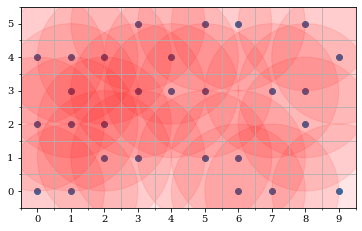

width=6, length=10, nbSensors=28
[[1.    1.    0.667 0.667 0.586 0.667 1.    1.    0.667 1.   ]
 [0.667 0.667 1.    1.    0.667 1.    1.    0.667 0.667 0.667]
 [1.    1.    1.    0.667 0.667 0.667 0.667 0.667 1.    0.667]
 [0.667 1.    0.667 1.    1.    1.    0.667 1.    1.    0.667]
 [1.    1.    1.    0.667 1.    0.667 0.667 0.667 0.667 1.   ]
 [0.667 0.667 0.667 1.    0.667 1.    1.    0.667 1.    0.667]]
cost=28, cov=49.25245310429355, cov(%)=100.0


In [244]:
length = 10
width = 6
sensingRange = 2
randomInit = np.random.randint(2, size=(width, length))
print(randomInit)

g = Grid(randomInit, sensingRange)
g.show_sensors()
print('width={}, length={}, nbSensors={}'.format(g.width, g.length, g.sensorsNb))

cost = g.compute_cost()
cov = g.compute_coverage()
print(g.gridCoverage)
print('cost={}, cov={}, cov(%)={}'.format(cost, cov, g.get_cov_percent()))

In [280]:
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

def oneDimToTwoDim(l):
    return np.array(list(divide_chunks(l, length)))

In [306]:
from pymoo.optimize import minimize
from pymoo.model.problem import Problem

# Define cost function using Grid class
class ProblemWrapper(Problem):
    def _evaluate(self, designs, out, *args, **kwargs):
        res = []
        for design in designs:
            g = Grid(oneDimToTwoDim(design), sensingRange)
            res.append((g.compute_cost(), -g.compute_coverage())) # -1 * coverage => maximization
            out['F'] = np.array(res)

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

# Define problem to minimize
varsNb = length * width
lowerBound = [0] * varsNb
upperBound = [1] * varsNb
print(varsNb)
problem = ProblemWrapper(n_var=varsNb, n_obj=2, xl=lowerBound, xu=upperBound)

# Configure integer variables
mask = ["int"] * varsNb
sampling = MixedVariableSampling(mask, {
    "int": get_sampling("int_random")
})
crossover = MixedVariableCrossover(mask, {
    "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
})
mutation = MixedVariableMutation(mask, {
    "int": get_mutation("int_pm", eta=3.0)
})


from pymoo.algorithms.nsga2 import NSGA2
algorithm = NSGA2(
    pop_size=30,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True
)

60


In [307]:
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=('n_gen', 30),
                   save_history=True,
                   #verbose=True
                  )

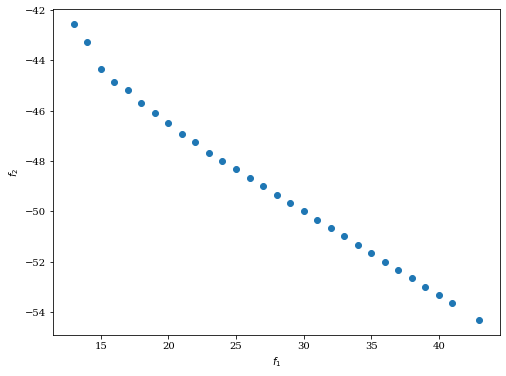

In [308]:
from pymoo.visualization.scatter import Scatter
Scatter().add(results.F).show()

In [330]:
print(results.F)
print(results.X)
# sortedRes = a[a[:,1].argsort()[::-1]]

[[ 13.    -42.534]
 [ 43.    -54.333]
 [ 14.    -43.282]
 [ 15.    -44.348]
 [ 18.    -45.676]
 [ 16.    -44.848]
 [ 17.    -45.181]
 [ 20.    -46.505]
 [ 19.    -46.091]
 [ 21.    -46.919]
 [ 22.    -47.252]
 [ 23.    -47.667]
 [ 29.    -49.667]
 [ 27.    -49.   ]
 [ 28.    -49.333]
 [ 36.    -52.   ]
 [ 31.    -50.333]
 [ 40.    -53.333]
 [ 32.    -50.667]
 [ 37.    -52.333]
 [ 24.    -48.   ]
 [ 26.    -48.667]
 [ 30.    -50.   ]
 [ 39.    -53.   ]
 [ 33.    -51.   ]
 [ 38.    -52.667]
 [ 35.    -51.667]
 [ 41.    -53.667]
 [ 34.    -51.333]
 [ 25.    -48.333]]
[[1 1 0 ... 0 0 0]
 [0 1 1 ... 1 0 1]
 [1 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 1]]


In [ ]:
resGrid = Grid(oneDimToTwoDim(results.X[0]), sensingRange)
resGrid.show_sensors()

array([[  3.   ],
       [-23.222]])

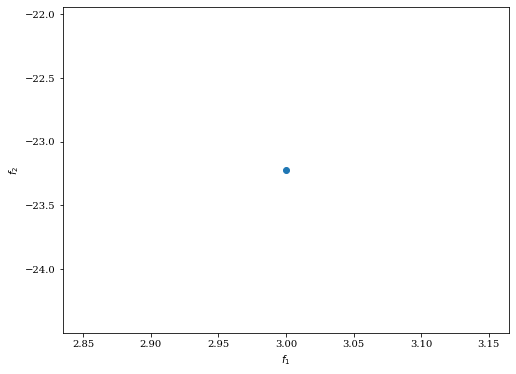

In [164]:
from pymoo.visualization.scatter import Scatter
Scatter().add(results.F).show()